# Introduction

Fred Etter - March 2019  

This notebook uses data from a Kaggle competition to predict if a customer will buy a product from Banco Santander during a typical transaction.  There are a total of 200,000 rows of customer transactions along with the binary outcome of whether they made a purchase or not.  There are 200 columns, or 200 features, to use as inputs to each of the models that are presented.  

The workflow in this notebook is as follows:
- import data
- clean data  
- data exploration  
- modeling and evaluation
- conclusion and discussion  


In [1]:
# Import necessary modules
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Import and clean the data  
In this section, the data is imported and cleaned.

Import the data from a csv file; then print the number of rows and columns of the data; then show the first 5 lines of the dataframe.

In [2]:
df = pd.read_csv(r"C:\Users\Fred\Documents\PythonDirectory\Unit 3\train_san.csv")
print(df.shape)
df.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


As you see, we have 200,000 rows and 202 columns.  All of the feature data are float numbers.  We can drop the ID_code later because it is irrevelant.  The var_1, var_2, etc are the column names given in the orginal dataset.  These features have not been specifically defined in Kaggle.  They are anonymized features that have been captured during customer transactions.

Next, we'll print the sum of the 'target' column which is the number of all of the rows where the customer bought a product.  Then we calculate the buy ratio.  As you can see here, a customer bought something about 10% of the time.

In [3]:
df['target'].sum()


20098

In [4]:
# print the sume of the target column
df['target'].sum()

# divide the target sum by the total number of rows
print("Customers average buy ratio, {}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.10049


Now we know we have a highly imbalanced dataset; 10% are 'buy' transactions, 90% are 'not buy' transactions.  In order to capture this imbalance we will use following technique:
- we will randomly remove most of the 'not buy' rows so the number of 'buy' and 'not buy' rows are even.  

Next, let's look at some of the data types in our dataset and check for NaN values.

In [5]:
df.dtypes.head()

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
dtype: object

We see that the 'target' data type is an integer which is what we'll need for the machine learning algorithms.  We have float values for the columns - which is what we want - and an 'ID_code' that is an object (we'll delete this column later).

In [6]:
df.isnull().sum().sum()

0

Perfect, no cleaning necessary for NaN values.

Drop the ID_code column since it is a string and irrelevant to making a buy or no_buy prediction.  Also, drop a random sample of 140,000 rows to account for hardware / memory limitations.

In [7]:
# drop ID_code column
df.drop(['ID_code'], axis=1, inplace=True)

# drop a random sample of 140,000 rows
df.drop(df.sample(140000).index, inplace=True)

Look at the number of rows of the data to make sure we dropped correct amount and then shuffle the data randomly to prepare data for modeling.

In [8]:
df.shape[0]
df = df.sample(frac=1)

Take another look at the data to see random shuffled rows.

In [9]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
178594,0,9.9742,1.4300,7.8024,4.5295,13.4226,-2.3222,6.2161,14.6409,3.4271,...,6.7485,8.1068,2.7352,3.9680,15.0545,1.7045,0.9947,8.4855,15.5738,-20.5092
9116,0,7.5156,-5.8345,9.7967,5.4679,13.7251,3.8856,5.4208,19.3190,-5.2980,...,-3.9053,5.2947,2.2685,2.8328,22.2946,-0.3044,3.2535,8.8833,18.9913,-13.9891
50827,0,13.2605,2.4159,10.7207,8.1731,10.4013,11.2528,6.3434,14.9289,-2.2773,...,-4.4861,13.1997,2.0307,4.6676,11.0844,-0.4671,7.6897,8.1620,15.3375,-1.4706
186701,0,11.2510,0.8563,12.6388,8.3593,9.4574,1.2289,3.8047,15.9770,2.0899,...,0.7010,4.2823,3.3725,4.6891,12.0540,-0.7408,2.5591,8.0221,12.3525,-11.1113
34358,0,9.1907,-8.2744,7.8372,3.7355,9.5015,-10.0760,5.2676,9.6833,-4.6616,...,7.4595,2.4451,0.1865,6.6854,15.2319,-1.4380,5.2290,8.2871,17.9951,-9.7060


At this point our data looks clean and ready to start exploring in more detail to look for features that might be better predictors for the target data.  We can use the pairplot and the heatmap functionality to begin this analysis.

## Data Exploration  
First, let's look at the correlation between the target and the features.

In [10]:
# use absolute value
np.absolute(df.corr().unstack().sort_values().drop_duplicates())

target   var_81     0.075851
         var_12     0.074008
         var_139    0.073177
var_146  target     0.063335
var_174  target     0.060231
target   var_76     0.059246
         var_166    0.059153
var_21   target     0.057564
target   var_148    0.055759
var_80   target     0.055584
target   var_115    0.055394
var_13   target     0.054756
target   var_34     0.053377
         var_198    0.050627
var_44   target     0.049474
target   var_165    0.049465
         var_149    0.049033
var_108  target     0.048506
var_33   target     0.047930
target   var_92     0.046153
         var_121    0.046134
var_109  target     0.046082
target   var_169    0.046059
var_154  target     0.042736
var_192  target     0.041731
var_127  target     0.041173
var_56   target     0.040860
target   var_9      0.039827
var_177  target     0.039686
target   var_122    0.039089
                      ...   
         var_95     0.037785
var_155  target     0.038120
target   var_67     0.038135
var_147  targe

Next, we'll look at the pairplot for the top 10 features as determined by the correlations found in the previous step.

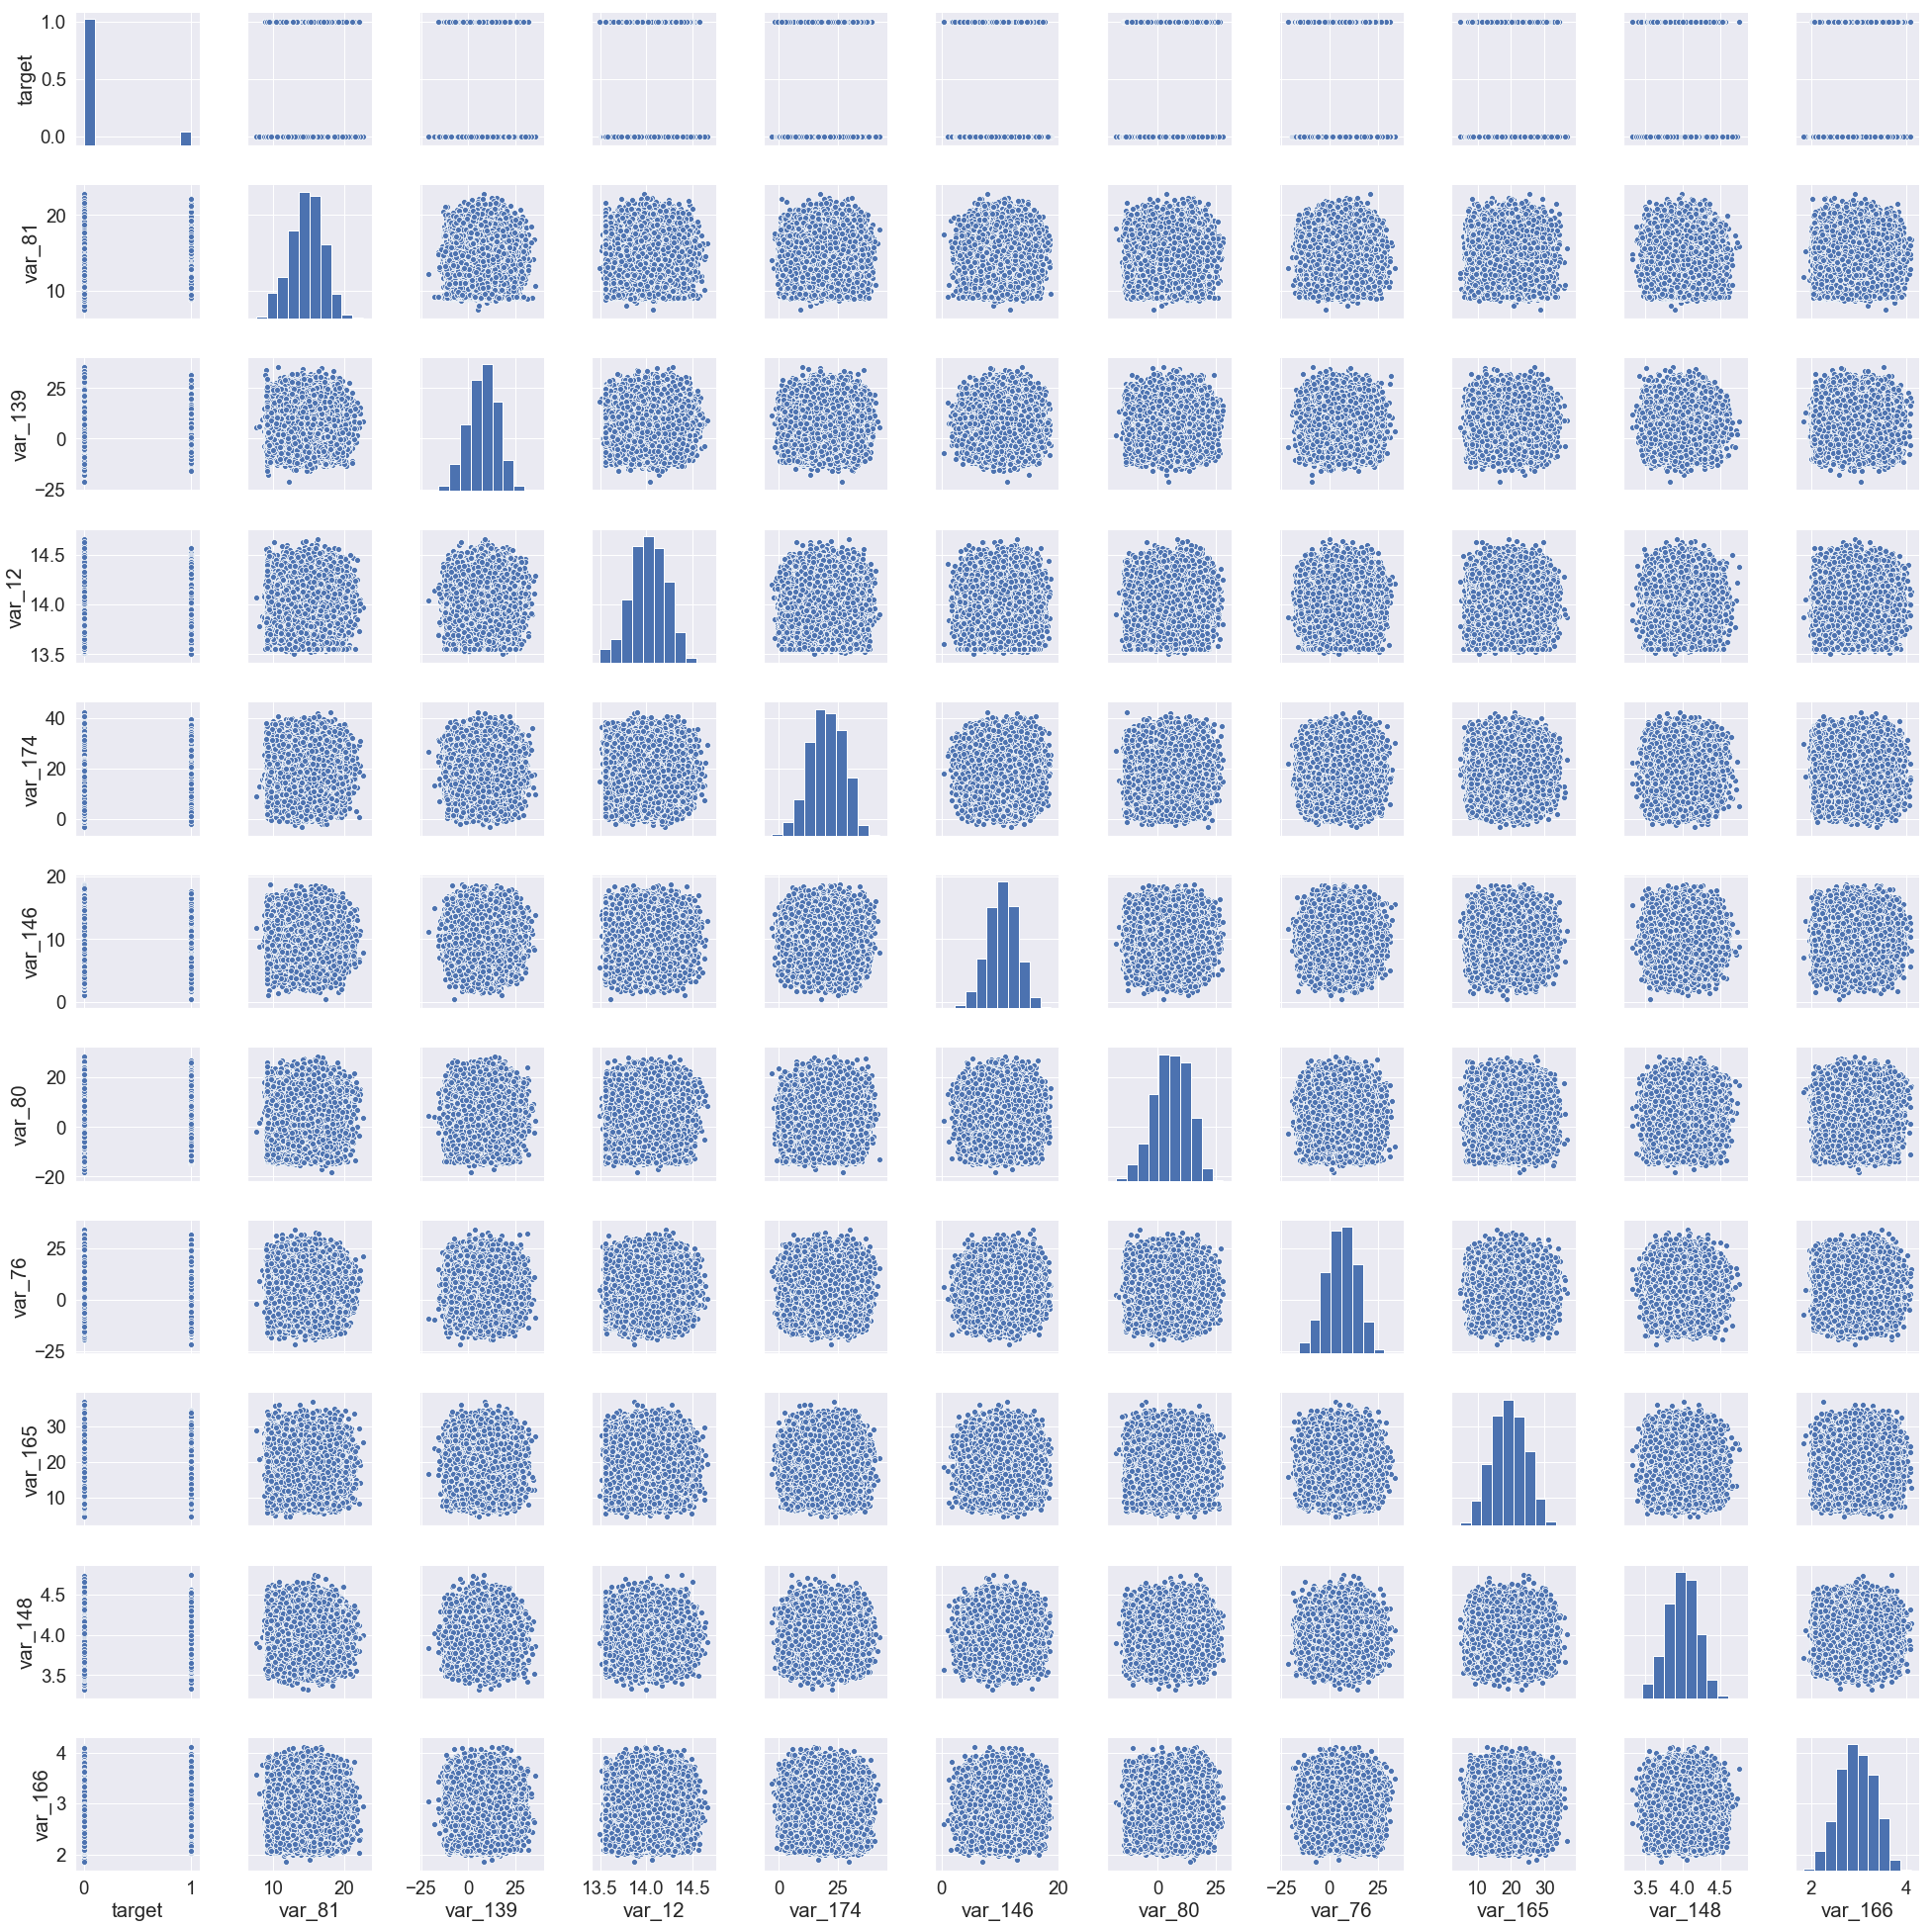

In [11]:
df_pp = df[['target', 'var_81', 'var_139', 'var_12', 'var_174', 
            'var_146', 'var_80', 'var_76', 'var_165', 'var_148', 'var_166']].copy()

sns.set(font_scale=1.7)
sns.pairplot(df_pp)
plt.show()

Nothing too exciting here; looks like a lot of noise.  Features look highly uncorrelated.  We do see that all of these features are very close to normally distributed.  We can also see the previously observed ratio of 1 buy transaction for every 10 transations.  

We can look at a heatmap for the 10 best features (determined above) for a more visual representation of the correlations between target and feature data.

In [12]:
# heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 7))
corr = df_pp.corr()
corr.style.background_gradient(cmap='coolwarm')

,target,var_81,var_139,var_12,var_174,var_146,var_80,var_76,var_165,var_148,var_166
target,1,-0.0758509,-0.0731771,-0.074008,-0.0602308,-0.0633353,-0.0555842,-0.0592461,-0.0494654,-0.0557592,-0.0591532
var_81,-0.0758509,1,0.000614158,0.00873027,0.00748413,0.00585614,0.00184133,0.00468441,0.00743861,0.00275705,0.00438106
var_139,-0.0731771,0.000614158,1,0.00514732,0.00749256,0.00582093,0.00328682,0.00444086,0.00815408,0.00774113,0.00861399
var_12,-0.074008,0.00873027,0.00514732,1,0.00932387,0.00904639,0.00389541,0.00600877,0.00061913,0.0043085,0.00174746
var_174,-0.0602308,0.00748413,0.00749256,0.00932387,1,0.00375576,0.000153095,0.00975271,-0.00252443,0.000737683,0.00404378
var_146,-0.0633353,0.00585614,0.00582093,0.00904639,0.00375576,1,0.00891478,-0.00240271,0.00286791,0.00452416,-0.000828867
var_80,-0.0555842,0.00184133,0.00328682,0.00389541,0.000153095,0.00891478,1,0.000592021,0.00784769,0.0117679,0.000458694
var_76,-0.0592461,0.00468441,0.00444086,0.00600877,0.00975271,-0.00240271,0.000592021,1,0.00191185,0.00114168,0.0123248
var_165,-0.0494654,0.00743861,0.00815408,0.00061913,-0.00252443,0.00286791,0.00784769,0.00191185,1,0.00670011,0.00730873
var_148,-0.0557592,0.00275705,0.00774113,0.0043085,0.000737683,0.00452416,0.0117679,0.00114168,0.00670011,1,-0.000687524


<Figure size 1080x504 with 0 Axes>

The above heatmap and correlation values show that there is very little correlation between the target variable and the top 10 best predictive features.  It looks like, at this point, we will need to incorporate many features (maybe most of the 200) to improve the predictive value of each model.

# Build the models and evaluate
The first step to building a good model is to separate the data into training and test data.  We'll train the model on the training data and test it with the test data.  This next line of code breaks the dataframe into 2 dataframes: 1 for training and 1 for test.

In [13]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

Confirm the new shapes of the 2 new dataframes.

In [14]:
df_train.shape

(48000, 201)

In [15]:
df_test.shape

(12000, 201)

Again, confirm the existence of about 10% 'buy' rows for the training data. (8034 is about 10% of 80,000 from above)

In [16]:
print("Customers average buy ratio, {}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.10253333333333334


Next, we need to balance the data to account for the current 9 to 1 ratio of 'not buy' to 'buy'.

In [17]:
# set variable buy_num to the total number of buys
buy_num = df_train['target'].sum()
print(buy_num)

# calculate the difference between the total rows and the number of buys
diff = df_train.shape[0] - buy_num

# calculate the number of rows to drop and drop those rows
df_train.drop(df_train.query('target < 1').sample(frac=(1 - (buy_num/diff))).index, inplace=True)
print(df_train.shape)

4942
(9884, 201)


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Confirm the new shape of the training data.  The new training dataframe has an equal number of 'buy' and 'not buy' rows.  As you can see, the number of rows has twice the number of the number of 'buys' in the dataframe.

In [18]:
print("Number of buys, {}".format(buy_num))
print("Number of rows and columns, {}".format(df_train.shape))

Number of buys, 4942
Number of rows and columns, (9884, 201)


We will use the Area Under the ROC curve insead of the more typical r-squared accuracy measure.  This is the preferred metric in accordance with Kaggle scoring.

Basic Logistic Regression as the first model used to calculate the ROC accuracy.  

In [19]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LogisticRegression(solver='sag')

# set features and dependent variable for training data
y_train = df_train['target'].values

# drop the 'target' column to obtain the feature inputs
df_train.drop(['target'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['target'].values

# drop the 'target' column to obtain the feature inputs
df_test.drop(['target'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

print('\nR-squared (training):')
print(regr.score(x_train, y_train))
print('\nR-squared (test):')
print(regr.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



R-squared (training):
0.7364427357345205

R-squared (test):
0.743

Duration: 0:00:01.207069


In [20]:
from sklearn import metrics
y_test_pred = regr.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.731248707480909

In [21]:
# 2.  Extra Trees Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import ExtraTreesClassifier

# Instantiate our model.
etc = ExtraTreesClassifier(n_estimators=1)

# fit model to data
etc.fit(x_train, y_train)

print('\nR-squared (training):')
print(etc.score(x_train, y_train))
print('\nR-squared (test):')
print(etc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
1.0

R-squared (test):
0.5405833333333333

Duration: 0:00:00.115007


In [22]:
from sklearn import metrics
y_test_pred = etc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5368756654079765

In [23]:
# 3.  Random Forest Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc = RandomForestClassifier(n_estimators=1)

# fit model to data
rfc.fit(x_train, y_train)

#------------------------------------------------------------------------------
sfm = SelectFromModel(rfc, threshold=0.001, max_features=10)
sfm.fit(x_train, y_train)
sfm.get_support()
selected_feat = df_train.columns[(sfm.get_support())]
len(selected_feat)
print(selected_feat)
#selected_feat(sfm.estimator_, feature_importances_).ravel().hist()
#------------------------------------------------------------------------------

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print('\nR-squared (training):')
print(rfc.score(x_train, y_train))
print('\nR-squared (test):')
print(rfc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Index(['var_1', 'var_6', 'var_35', 'var_53', 'var_81', 'var_87', 'var_107',
       'var_110', 'var_115', 'var_154'],
      dtype='object')

R-squared (training):
0.8360987454471873

R-squared (test):
0.5441666666666667

Duration: 0:00:00.445026


Printing the most imprtant features as determined by the random forest algorithm.

In [24]:
print((feature_importances).head(10))

         importance
var_22     0.018069
var_33     0.017389
var_76     0.016538
var_21     0.015947
var_172    0.014651
var_166    0.013303
var_177    0.013067
var_110    0.011677
var_151    0.011311
var_199    0.011018


In [25]:
from sklearn import metrics
y_test_pred = rfc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5513423050115274

In [26]:
# 4.  Gradient Boosting Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc = GradientBoostingClassifier(n_estimators=1)

# fit model to data
gbc.fit(x_train, y_train)

print('\nR-squared (training):')
print(gbc.score(x_train, y_train))
print('\nR-squared (test):')
print(gbc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.5945973290165925

R-squared (test):
0.7453333333333333

Duration: 0:00:00.448026


In [27]:
from sklearn import metrics
y_test_pred = gbc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5883608177145964

With just the 10 best features (from Random Forest 'feature_selections_').

In [28]:
# 5.  GBC with just the 10 best features (n_estimators=500)

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_10 = GradientBoostingClassifier(n_estimators=1)

x_train_10 = sklearn.preprocessing.normalize(df_train[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                    'var_110', 'var_139', 'var_146']])

x_test_10 = sklearn.preprocessing.normalize(df_test[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                                              'var_110', 'var_139', 'var_146']])

# fit model to data
gbc_10.fit(x_train_10, y_train)

print('\nR-squared (training):')
print(gbc_10.score(x_train_10, y_train))
print('\nR-squared (test):')
print(gbc_10.score(x_test_10, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.5920679886685553

R-squared (test):
0.72275

Duration: 0:00:00.047002


In [29]:
from sklearn import metrics
y_test_pred = gbc_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5893775993995053

In [30]:
# 6.  Support Vector Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.svm import SVC

# Instantiate our model.
sv_c = SVC(gamma='auto')

# fit model to data
sv_c.fit(x_train, y_train)

print('\nR-squared (training):')
print(sv_c.score(x_train, y_train))
print('\nR-squared (test):')
print(sv_c.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.6682517199514366

R-squared (test):
0.71575

Duration: 0:01:32.515292


In [31]:
from sklearn import metrics
y_test_pred = sv_c.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6566605902312365

In [32]:
# 7.  Voting Classifier with LR, RFC, and NB

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(solver='sag')
clf2 = RandomForestClassifier(n_estimators=500)
clf3 = GaussianNB()
# clf4 = GradientBoostingClassifier(n_estimators=200)
# clf5 = SVC

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

eclf1 = eclf1.fit(x_train, y_train)

print('\nR-squared (training):')
print(sv_c.score(x_train, y_train))
print('\nR-squared (test):')
print(sv_c.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.6682517199514366

R-squared (test):
0.71575

Duration: 0:02:49.196677


In [33]:
from sklearn import metrics
y_test_pred = eclf1.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7852557081472743

In [34]:
# 8.  Naive Bayes Bernoulli Classifier

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(x_train, y_train)

print('\nR-squared (training):')
print(bnb.score(x_train, y_train))
print('\nR-squared (test):')
print(bnb.score(x_test, y_test))



R-squared (training):
0.6575273168757588

R-squared (test):
0.6575833333333333


In [35]:
from sklearn import metrics
y_test_pred = bnb.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.652932773688524

Now, Bernoulli NB with just the 10 best features.

In [36]:
# 9.  Naive Bayes Bernoulli Classifier with just 10 best features

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb_10 = BernoulliNB()

# Fit our model to the data.
bnb_10.fit(x_train_10, y_train)

print('\nR-squared (training):')
print(bnb_10.score(x_train_10, y_train))
print('\nR-squared (test):')
print(bnb_10.score(x_test_10, y_test))


R-squared (training):
0.5696074463779847

R-squared (test):
0.5336666666666666


In [37]:
from sklearn import metrics
y_test_pred = bnb_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5697179053148386

## Conclusion and discussion
First of all the number of rows dropped (140,000) definitely has an impact on the performance of each model.  Another significant influence to model accuracy (area under the ROC curve) was the number of 'n_estimators' used in the random forest, extra tree classifier and gradient boosting classifier.  Using 100 n_estimators achieved better results than 10 and 500 got better results than 100; however, the higher this number, the higher the solve times.  There is definitely a trade off.  

Using just the 10 best features was a quick way to test to see if eliminating some noise in the data could yield better results.  These test results did not produce better results; they were worse.  It seems that eliminating some of the weaker correlated features could produce better accuracy measures, but which ones to eliminate (out of the 200) is a tricky question.  More study is needed.  

The results for all 9 models (in decreasing AUC ROC performance) are as follows:
- Voting Classifier with LR, RFC, and NB:  0.784
- Gradient Boosting Classifier:  0.783
- Extra Tree Classifier:  0.770
- Random Forest Classifier:  0.765
- Logistic Regression:  0.743
- Support Vector Classifier:  0.665
- Bernoulli Naive Bayes:  0.648
- Graient Boosting with 10 features:  0.627
- Bernoulli NB with 10 features:  0.566  

Another major factor in increasing accuracy results was adjusting for class imbalance.  Models that did not make the adjustment were quickly discarded and performed significantly worse - around 10 to 15% worse - than models shown in this study which made the adjustment.  

Overall, the best models were ensemble models.  In fact, they comprised the top 4 performing models.  Many more modeling techniques exist and can be studied in the future to compare against the resluts obtained here.  